In [4]:
# ======================================================
# 1️⃣ Setup & Imports
# ======================================================
!pip install kagglehub geopandas statsmodels matplotlib --quiet

import kagglehub
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")

# ======================================================
# 2️⃣ Download dataset from Kaggle via KaggleHub
# ======================================================
path = kagglehub.dataset_download("amineamllal/california-poc")
print("✅ Dataset downloaded to:", path)

import os
# Find CSV file dynamically
for file in os.listdir(path):
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        break

print("✅ Using file:", dataset_path)

✅ Dataset downloaded to: /Users/neilk/.cache/kagglehub/datasets/amineamllal/california-poc/versions/1
✅ Using file: /Users/neilk/.cache/kagglehub/datasets/amineamllal/california-poc/versions/1/Database.csv


Columns: ['Unnamed: 0', 'Time', 'Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature', 'PV_production', 'Wind_production', 'Electric_demand']


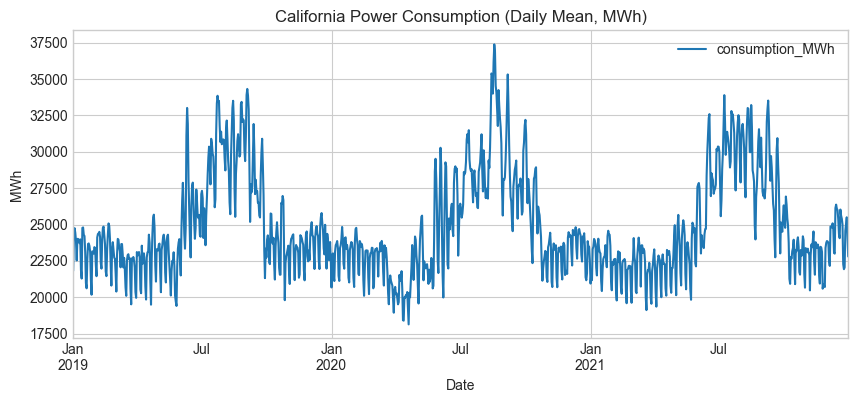

In [9]:
# ======================================================
# 3️⃣ Load & Prepare Data (Fixed for California POC)
# ======================================================
df = pd.read_csv(dataset_path)
print("Columns:", df.columns.tolist())
df.head()

# Explicitly set the right columns
df = df[["Time", "Electric_demand"]].rename(
    columns={"Time": "date", "Electric_demand": "consumption_MWh"}
)

# Convert to datetime and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

# Resample hourly → daily mean
df_daily = df.resample("D").mean().dropna()

# Plot daily demand
df_daily.plot(figsize=(10,4), title="California Power Consumption (Daily Mean, MWh)")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.show()

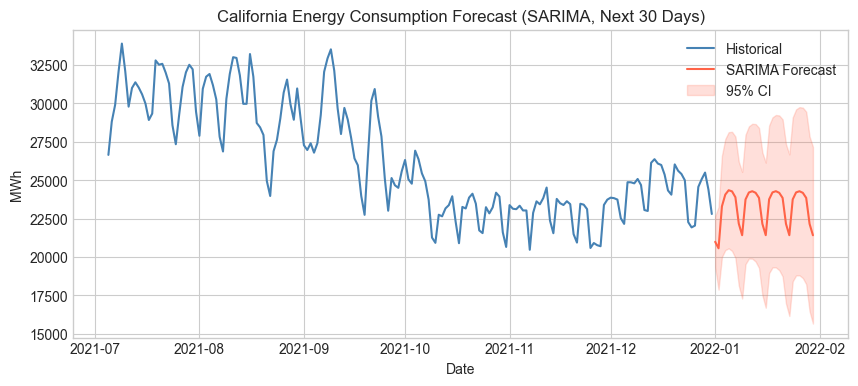

In [13]:
# ======================================================
# 4️⃣ Fit Seasonal ARIMA (SARIMA)
# ======================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define model: (p,d,q) + (P,D,Q,s)
# 7-day seasonal period because demand is weekly cyclical
model = SARIMAX(df_daily["consumption_MWh"],
                order=(2,1,2),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

fit = model.fit(disp=False)

# Forecast next 30 days
steps = 30
forecast = fit.get_forecast(steps=steps)
forecast_index = pd.date_range(df_daily.index[-1] + pd.Timedelta(days=1),
                               periods=steps, freq="D")

# Extract forecast mean + CI
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,4))
plt.plot(df_daily.index[-180:], df_daily["consumption_MWh"][-180:], label="Historical", color="steelblue")
plt.plot(forecast_index, forecast_mean, label="SARIMA Forecast", color="tomato")
plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                 color="tomato", alpha=0.2, label="95% CI")

plt.title("California Energy Consumption Forecast (SARIMA, Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.legend()
plt.show()

In [14]:
# ======================================================
# 5️⃣ Create county-level forecast variation
# ======================================================
CA_GEOJSON = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
gdf = gpd.read_file(CA_GEOJSON)
gdf = gdf.rename(columns={"name": "county"})

# Base forecast = mean of next 30 days
base_forecast = forecast_df["forecast_MWh"].mean()

# Add synthetic +/- 5% variation by county
rng = np.random.default_rng(42)
variation = rng.normal(0, 0.05, len(gdf))
gdf["forecast_MWh"] = base_forecast * (1 + variation)

gdf.head()


,county,cartodb_id,created_at,updated_at,geometry,forecast_MWh
0,Alameda,1,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"MULTIPOLYGON (((-122.31293 37.89733, -122.2884...",24209.564436
1,Alpine,2,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.07239 38.70277, -119.96495 38.7...",22606.260638
2,Amador,3,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.02726 38.48925, -121.02741 38.5...",24741.018717
3,Butte,4,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.87925 39.30361, -121.90831 39.3...",24967.693410
4,Calaveras,5,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.87605 38.02889, -120.91875 38.0...",21520.003204


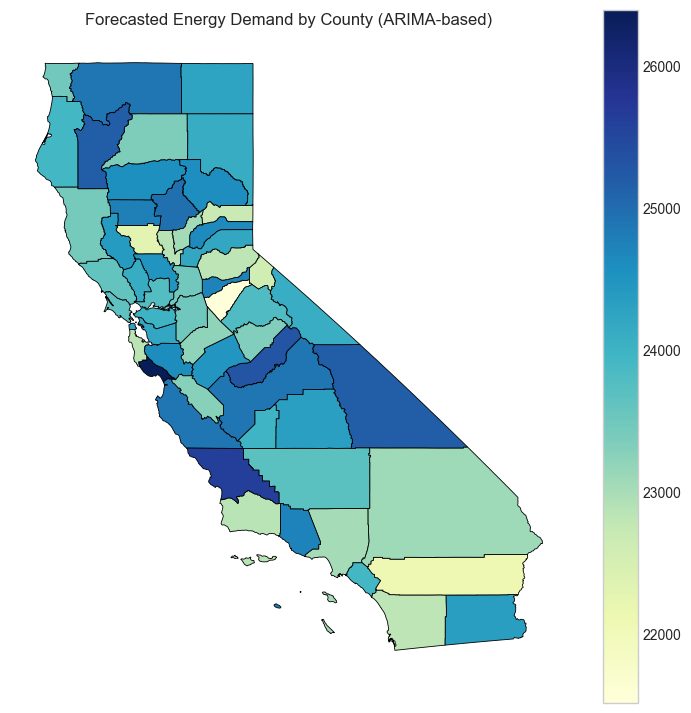

In [15]:
# ======================================================
# 6️⃣ Choropleth Visualization
# ======================================================
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
gdf.plot(column="forecast_MWh", cmap="YlGnBu", linewidth=0.6,
         edgecolor="black", legend=True, ax=ax)
plt.title("Forecasted Energy Demand by County (ARIMA-based)")
plt.axis("off")
plt.show()